In [ ]:
!ollama pull "llama3.2"

In [27]:
from langchain_community.llms import Ollama
from langchain.memory import ConversationBufferWindowMemory
from langchain.chains import ConversationChain
from langchain_ollama import ChatOllama
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage
from langchain_core.tools import tool


model = ChatOllama(
    #model = "llama3.2",
    model = 'mistral',
    temperature = 0,
)


In [28]:
from langchain_core.tools import tool

@tool
def add(a: int, b: int) -> int:
    """Do the addition of the two numbers a and b"""
    return a + b

@tool
def mul(a: int, b: int) -> int:
    """Do the multiplication of the two numbers a and b"""
    return a * b

@tool
def sub(a: int, b: int) -> int:
    """Do the substraction of the two numbers a and b"""
    return a - b

@tool
def div(a: int, b: int) -> int:
    """Do the division of the two numbers a and b"""
    try:
        return a / b
    except:
        return -1

In [29]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    api_call_count: int = 0

llm_with_tools = model.bind_tools([add, mul, sub, div])

In [36]:
from langchain_core.messages import HumanMessage, ToolMessage

tool_mapping = {"add": add, "mul": mul, "sub": sub, "div": div}

messages = [
    HumanMessage(
        "Could you add 5 and 7 please?"
    ),
    HumanMessage(
        "Could you divide 100 by 5 please?"
    )
]
llm_output = llm_with_tools.invoke(messages)
messages.append(llm_output)
print(messages)

[HumanMessage(content='Could you add 5 and 7 please?', additional_kwargs={}, response_metadata={}), HumanMessage(content='Could you divide 100 by 5 please?', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'mistral', 'created_at': '2024-11-11T09:37:58.75658974Z', 'message': {'role': 'assistant', 'content': '', 'tool_calls': [{'function': {'name': 'add', 'arguments': {'a': 5, 'b': 7}}}, {'function': {'name': 'div', 'arguments': {'a': 100, 'b': 5}}}]}, 'done_reason': 'stop', 'done': True, 'total_duration': 1219986014, 'load_duration': 10830576, 'prompt_eval_count': 308, 'prompt_eval_duration': 231582000, 'eval_count': 96, 'eval_duration': 835377000}, id='run-63bc151a-dc39-4490-80d6-1c82124240e3-0', tool_calls=[{'name': 'add', 'args': {'a': 5, 'b': 7}, 'id': 'deb69070-0149-4cb3-9576-76965bc10068', 'type': 'tool_call'}, {'name': 'div', 'args': {'a': 100, 'b': 5}, 'id': '683f108a-50de-419e-9f8a-cdd86b6f9247', 'type': 'tool

In [37]:
for tool_call in llm_output.tool_calls:
    tool = tool_mapping[tool_call["name"].lower()]
    tool_output = tool.invoke(tool_call["args"])
    messages.append(ToolMessage(content=tool_output, tool_call_id=tool_call["id"]))

llm_with_tools.invoke(messages)

name='add' description='Do the addition of the two numbers a and b' args_schema=<class 'langchain_core.utils.pydantic.add'> func=<function add at 0x7f8d188971a0>
deb69070-0149-4cb3-9576-76965bc10068
name='div' description='Do the division of the two numbers a and b' args_schema=<class 'langchain_core.utils.pydantic.div'> func=<function div at 0x7f8d18894180>
683f108a-50de-419e-9f8a-cdd86b6f9247


AIMessage(content='12 is the result of adding 5 and 7, and 20.0 is the result of dividing 100 by 5.', additional_kwargs={}, response_metadata={'model': 'mistral', 'created_at': '2024-11-11T09:37:59.370709056Z', 'message': {'role': 'assistant', 'content': '12 is the result of adding 5 and 7, and 20.0 is the result of dividing 100 by 5.'}, 'done_reason': 'stop', 'done': True, 'total_duration': 601874911, 'load_duration': 8016812, 'prompt_eval_count': 89, 'prompt_eval_duration': 25608000, 'eval_count': 34, 'eval_duration': 264229000}, id='run-147ee565-f66e-484c-9129-a8e753540211-0', usage_metadata={'input_tokens': 89, 'output_tokens': 34, 'total_tokens': 123})

# Lang Graph creation

In [44]:
def call_model(state: AgentState):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}


def router(input: list[HumanMessage]):
    print(input["messages"][1].content)
    
    if ("add" or "adding") in input["messages"][1].content:
        return "add"
    elif "multiply" in input["messages"][1].content:
        return "mul"
    elif "substract" in input["messages"][1].content:
        return "sub"
    elif ("divide" or "division") in input["messages"][1].content:
        return "div"


def call_tool(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    tool_call = last_message.tool_calls[0]
    tool = tool_mapping[tool_call["name"].lower()]
    tool_output = tool.invoke(tool_call["args"])
    # print("Tool output:", tool_output)
    tool_message = ToolMessage(content=tool_output, tool_call_id=tool_call["id"])
    return {"messages": [tool_message]}

In [39]:
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

workflow = StateGraph(AgentState)

workflow.add_node("agent", call_model)
workflow.add_node("action", call_tool)


workflow.set_entry_point("agent")

workflow.add_edge("agent", "action")
workflow.add_edge("action", END)


app = workflow.compile()

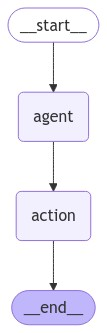

In [40]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

In [43]:
from langchain_core.messages import SystemMessage

system_message = SystemMessage(
    content="You are responsible for answering user questions. You use tools for that."
)
human_message = HumanMessage(content="What is the result of adding 7 and 5?")
messages = [system_message, human_message]

result = app.invoke({"messages": messages})

last mesage
content='' additional_kwargs={} response_metadata={'model': 'mistral', 'created_at': '2024-11-11T09:40:17.475521456Z', 'message': {'role': 'assistant', 'content': '', 'tool_calls': [{'function': {'name': 'add', 'arguments': {'a': 7, 'b': 5}}}]}, 'done_reason': 'stop', 'done': True, 'total_duration': 956702163, 'load_duration': 8652676, 'prompt_eval_count': 312, 'prompt_eval_duration': 165937000, 'eval_count': 68, 'eval_duration': 633927000} id='run-64dc3b2b-6fee-4352-9347-0f990c992263-0' tool_calls=[{'name': 'add', 'args': {'a': 7, 'b': 5}, 'id': 'bdaf8f97-0860-429e-ae4f-e31a3fe43c43', 'type': 'tool_call'}] usage_metadata={'input_tokens': 312, 'output_tokens': 68, 'total_tokens': 380}
tool call
{'name': 'add', 'args': {'a': 7, 'b': 5}, 'id': 'bdaf8f97-0860-429e-ae4f-e31a3fe43c43', 'type': 'tool_call'}
tool output
12
Tool output: 12
